## Llama-3.1-8B를 이용한 퍼플렉시티 계산

https://huggingface.co/meta-llama/Llama-3.1-8B

In [ ]:
!huggingface-cli download meta-llama/Llama-3.1-8B --include "original/*" --local-dir Llama-3.1-8B

In [39]:
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
model_name = 'meta-llama/Llama-3.1-8B'

tokenizer = AutoTokenizer.from_pretrained(model_name)

free_in_GB = int(torch.cuda.mem_get_info()[0]/1024**3) ## 다 써버리는 건 좀 가혹하지 않나...
max_memory = f'{int(torch.cuda.mem_get_info()[0]/1024**3)-2}GB'

n_gpus = torch.cuda.device_count()
max_memory = {i: max_memory for i in range(n_gpus)}

model = AutoModelForCausalLM.from_pretrained(
  model_name,
  device_map='auto',
  # load_in_4bit=True, ## 양자화 하면 퍼플렉시티 제대로 안구해짐
  max_memory=max_memory,
  do_sample=True,
  torch_dtype="auto"
)

model.to("cuda")
model.eval()

2025-09-10 20:55:08.748422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757505308.764328 1564709 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757505308.769832 1564709 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757505308.782947 1564709 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757505308.782961 1564709 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757505308.782963 1564709 computation_placer.cc:177] computation placer alr

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
texts = pd.read_excel("~/Seminar/paper/combined_data_NLP.xlsx")[["model", "answer"]]
texts.head()

In [ ]:
size_lst = []

for txt in texts["answer"]:
    enc = tokenizer(txt, return_tensors = "pt")
    size_lst.append(enc.input_ids.size(1))

max(size_lst) ## 2799 tokens

In [ ]:
ppls = []

for i, txt in enumerate(texts["answer"]) :
    encoding = tokenizer(txt, return_tensors = "pt").to("cuda")
    
    ## 모델의 최대 콘텍스트가 입력 텍스트의 max token size를 아득히 상회하므로(128k) -> 그대로 negative_log_likelihood 계산
    with torch.no_grad():
        outputs = model(encoding.input_ids, labels = encoding.input_ids)
        nll = outputs.loss
        ppl = torch.exp(nll)

    ppls.append(ppl.item())

    if i % 1000 == 0 :
        print(f"{i}번째 문장의 퍼플렉시티 계산 중")

0번째 문장의 퍼플렉시티 계산 중
1000번째 문장의 퍼플렉시티 계산 중
2000번째 문장의 퍼플렉시티 계산 중
3000번째 문장의 퍼플렉시티 계산 중
4000번째 문장의 퍼플렉시티 계산 중
5000번째 문장의 퍼플렉시티 계산 중
6000번째 문장의 퍼플렉시티 계산 중
7000번째 문장의 퍼플렉시티 계산 중
8000번째 문장의 퍼플렉시티 계산 중
9000번째 문장의 퍼플렉시티 계산 중
10000번째 문장의 퍼플렉시티 계산 중
11000번째 문장의 퍼플렉시티 계산 중
12000번째 문장의 퍼플렉시티 계산 중
13000번째 문장의 퍼플렉시티 계산 중
14000번째 문장의 퍼플렉시티 계산 중


In [95]:
texts["perp"] = ppls
texts.to_csv("Llama_perp.csv", index = False)

## 시각화

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df = pd.read_csv("Llama_perp.csv")

In [41]:
df.perp.max()

np.float64(282.6589050292969)

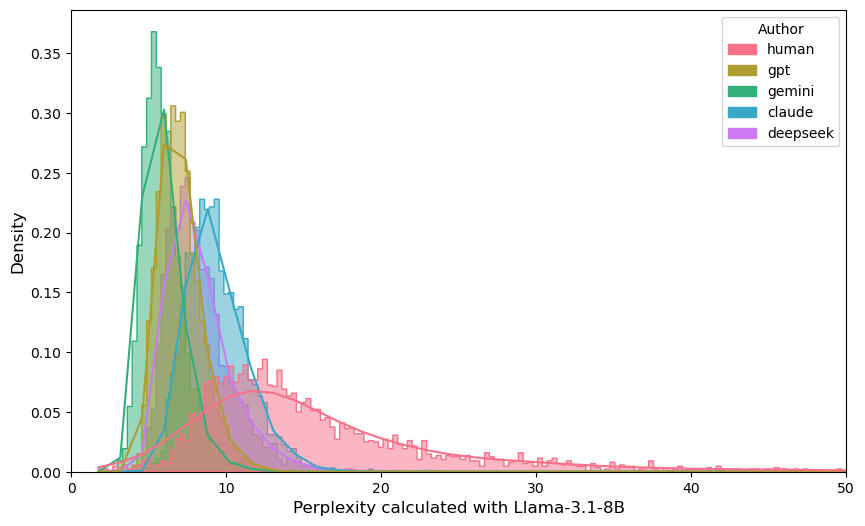

In [40]:
# 히스토그램 (단어 수)
unique_models = ["human", "gpt", "gemini", "claude", "deepseek"] ## 논문에서 정의한 레이블링 순서대로 정렬
palette = sns.color_palette("husl", len(unique_models))

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='perp', hue='model', kde=True, palette=palette,
             stat="density", common_norm=False, element="step", alpha=0.5, hue_order=unique_models)
plt.xlabel('Perplexity calculated with Llama-3.1-8B', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(0, 50) ## 절사됨

handles = [mpatches.Patch(color=palette[i], label=unique_models[i]) for i in range(len(unique_models))] ## 범례 패치
plt.legend(title='Author', handles=handles)
# plt.show()
plt.savefig("perp_histogram_labeled.png", dpi=300, bbox_inches = "tight")

### 스트라이딩이 필요한 경우 : 텍스트 컨텍스트 길이가 긴 경우

In [ ]:
max_length = model.config.max_position_embeddings ## max size를 상회함
stride = 512 ## max size : 2799
device = "cuda"

for i, row in texts.iterrows():
    if i == 0 :
        encoding = tokenizer(row["answer"], return_tensors = "pt").to("cuda")
        seq_len = encoding.input_ids.size(1)
        
        nll_sum = 0.0
        n_tokens = 0
        prev_end_loc = 0

        for begin_loc in tqdm(range(0, seq_len, stride)):
            end_loc = min(begin_loc + max_length, seq_len)
            trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
            input_ids = encoding.input_ids[:, begin_loc:end_loc].to(device)
            target_ids = input_ids.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids, labels=target_ids)

                # loss is calculated using CrossEntropyLoss which averages over valid labels
                # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
                # to the left by 1.
                neg_log_likelihood = outputs.loss

            # Accumulate the total negative log-likelihood and the total number of tokens
            num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
            batch_size = target_ids.size(0)
            num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
            nll_sum += neg_log_likelihood * num_loss_tokens
            n_tokens += num_loss_tokens

            prev_end_loc = end_loc
            if end_loc == seq_len:
                break

        avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
        ppl = torch.exp(avg_nll)


  0%|          | 0/1 [00:00<?, ?it/s]
